In [1]:
from keras.layers import *
from keras.models import *
from keras.optimizers import *

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../record1/driving_log.csv')
df.columns = ['center', 'left', 'right', 'dir', 'acc', 'nacc', 'speed']
print df['speed'].mean(), df['dir'].mean(), df['dir'].max(), df['dir'].min(), (df['dir'] > 0).mean()
df.head()

29.9117791845 -0.000347397677102 1.0 -1.0 0.410322837784


,center,left,right,dir,acc,nacc,speed
0,/home/ypw/Desktop/record1/IMG/center_2017_10_1...,/home/ypw/Desktop/record1/IMG/left_2017_10_19_...,/home/ypw/Desktop/record1/IMG/right_2017_10_19...,0.000000,1.0,0,30.19036
1,/home/ypw/Desktop/record1/IMG/center_2017_10_1...,/home/ypw/Desktop/record1/IMG/left_2017_10_19_...,/home/ypw/Desktop/record1/IMG/right_2017_10_19...,0.000000,1.0,0,30.19037
2,/home/ypw/Desktop/record1/IMG/center_2017_10_1...,/home/ypw/Desktop/record1/IMG/left_2017_10_19_...,/home/ypw/Desktop/record1/IMG/right_2017_10_19...,0.050000,1.0,0,30.18969
3,/home/ypw/Desktop/record1/IMG/center_2017_10_1...,/home/ypw/Desktop/record1/IMG/left_2017_10_19_...,/home/ypw/Desktop/record1/IMG/right_2017_10_19...,0.200000,1.0,0,30.17970
4,/home/ypw/Desktop/record1/IMG/center_2017_10_1...,/home/ypw/Desktop/record1/IMG/left_2017_10_19_...,/home/ypw/Desktop/record1/IMG/right_2017_10_19...,0.137228,1.0,0,30.18929


(160, 320, 3)


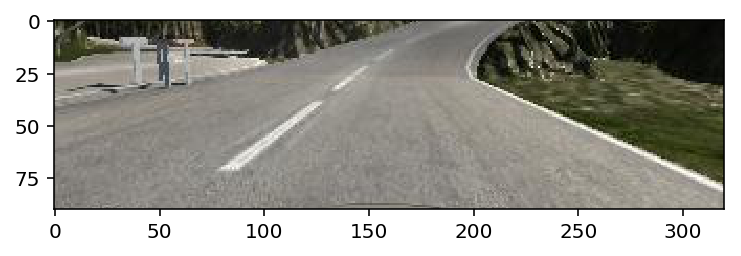

In [3]:
img = cv2.imread(df['center'][0])
print img.shape
img = img[50:-20,:]
plt.imshow(img[:,:,::-1])

In [4]:
n = len(df)
X = np.zeros((n, 160, 320, 3), dtype=np.uint8)
y = df['dir'].values

for i in tqdm(range(n)):
    X[i] = cv2.imread(df['center'][i])[:,:,::-1]


100%|██████████| 5018/5018 [00:03<00:00, 1359.39it/s]


In [5]:
X = np.concatenate([X, X[:,::-1]], axis=0)
y = np.concatenate([y, -y], axis=0)

In [6]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

In [7]:
inputs = Input(X.shape[1:])

x = inputs
x = Cropping2D(((50, 20), (0, 0)))(x)
x = Lambda(lambda x:x/255-0.5)(x)
for i in range(4):
    for j in range(2):
        x = Conv2D(32, 3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='tanh')(x)

model = Model(inputs, x)
model.compile(loss='mse', optimizer='adam')

In [8]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
model.fit(X, y, batch_size=128, epochs=10, validation_split=0.2)

Train on 8028 samples, validate on 2008 samples
Epoch 1/10
8028/8028 [==============================] - 17s - loss: 0.1564 - val_loss: 0.1210
Epoch 2/10
8028/8028 [==============================] - 14s - loss: 0.1099 - val_loss: 0.0917
Epoch 3/10
8028/8028 [==============================] - 14s - loss: 0.0943 - val_loss: 0.0855
Epoch 4/10
8028/8028 [==============================] - 14s - loss: 0.0841 - val_loss: 0.0773
Epoch 5/10
8028/8028 [==============================] - 14s - loss: 0.0749 - val_loss: 0.0750
Epoch 6/10
8028/8028 [==============================] - 14s - loss: 0.0680 - val_loss: 0.0680
Epoch 7/10
8028/8028 [==============================] - 14s - loss: 0.0630 - val_loss: 0.0678
Epoch 8/10
8028/8028 [==============================] - 14s - loss: 0.0592 - val_loss: 0.0652
Epoch 9/10
8028/8028 [==============================] - 14s - loss: 0.0533 - val_loss: 0.0617
Epoch 10/10
8028/8028 [==============================] - 14s - loss: 0.0511 - val_loss: 0.0567


In [10]:
model.save('model.h5')

In [11]:
index = np.random.choice(n, 128)
y_pred = model.predict(X[index])[:,0]
print ((y_pred > 0) == (y[index] > 0)).mean()
list(zip(y_pred, y[index]))[:32]

0.8359375


[(-0.39626631, -0.092952699999999999),
 (-0.10447261, 0.10000000000000001),
 (-0.63416046, -1.0),
 (0.41482055, 0.50385119999999994),
 (0.36154589, 0.3415842),
 (0.30524302, 0.34165759999999995),
 (-0.009658725, -0.25749640000000001),
 (0.030508028, -0.0),
 (0.56406283, 0.78433599999999992),
 (0.043942057, -0.0),
 (0.1646094, 0.30709130000000001),
 (-0.022283807, -0.33401579999999997),
 (0.36760256, 0.10274860000000001),
 (0.11872706, -0.118995),
 (-0.19911882, -0.30055929999999997),
 (-0.3741897, -0.45299220000000007),
 (0.17399199, 0.186775),
 (0.040043991, -0.0),
 (-0.045413919, 0.0),
 (0.58580446, 0.55297850000000004),
 (0.36871827, 0.55000009999999999),
 (-0.35753062, -0.17422839999999998),
 (0.27684528, 0.72779130000000003),
 (-0.0082780709, 0.0),
 (0.088154666, 0.050000000000000003),
 (-0.18251625, -0.050000000000000003),
 (-0.39994872, -0.43237690000000001),
 (0.17244221, 0.0),
 (0.029890604, -0.0),
 (-0.24153672, -0.48917559999999993),
 (0.42209303, 0.40000000000000002),
 (-0.